# Project Part 2
**Eliya Zaguri ID 207313131**

[GitHub Repository](https://github.com/eliyazaguri/car-price-prediction-project)

In [2]:
# איחוד כל המופעים של Lexsus ו- לקסוס לשם אחיד
def clean_manufactor_names(df):
    df['manufactor'] = df['manufactor'].replace(['Lexsus', 'לקסוס'], 'לקסוס')
    return df

In [3]:
def add_important_words_count(df):
    # רשימת המילים שיכולות להעלות את ערך הרכב
    important_words = ["כחדש", "שמור", "שמורה", "ללא תאונות","מתוחזק","מקורה","נהג יחיד","חדש","אחרי טיפול"
                       ,"מגנזיום","מורשה","חסכוני","מובילאיי","בבדיקה","מערכת"]

    # פונקציה פנימית לספירת המילים החשובות בתיאור
    def count_important_words(description, words):
        if not description or description.strip() == '':
            return 0
        count = 0
        for word in words:
            if word in description:
                count += 1
        return count

    # יצירת העמודה החדשה עם ספירת המילים החשובות
    df['important_words_count'] = df['Description'].apply(lambda x: count_important_words(str(x), important_words))
    df['important_words_count'] = df['important_words_count'] * 100
    
    return df

In [4]:
def fill_missing_gear(df):
    # מציאת הערך הנפוץ ביותר בעמודת Gear
    most_common_gear = df['Gear'].mode()[0]

    # מילוי הערך החסר בעמודת Gear עם הערך הנפוץ ביותר
    df['Gear'] = df['Gear'].fillna(most_common_gear)
    
    return df

In [5]:
def fill_missing_capacity_and_engine_type(df):
    # שלב 1: יצירת מיפוי לערך הנפוץ ביותר עבור כל שילוב של יצרן ודגם עבור capacity_Engine ו- Engine_type
    capacity_mapping = df.groupby(['manufactor', 'model'])['capacity_Engine'].apply(
        lambda x: x.mode()[0] if not x.mode().empty else None
    )

    engine_type_mapping = df.groupby(['manufactor', 'model'])['Engine_type'].apply(
        lambda x: x.mode()[0] if not x.mode().empty else None
    )

    # שלב 2: פונקציות להשלמת ערכים חסרים עבור capacity_Engine ו- Engine_type לפי יצרן ודגם
    def fill_capacity_engine(row):
        if pd.isna(row['capacity_Engine']):
            return capacity_mapping.get((row['manufactor'], row['model']), row['capacity_Engine'])
        return row['capacity_Engine']

    def fill_engine_type(row):
        if pd.isna(row['Engine_type']):
            return engine_type_mapping.get((row['manufactor'], row['model']), row['Engine_type'])
        return row['Engine_type']

    # שלב 3: החלת הפונקציות על העמודות
    df['capacity_Engine'] = df.apply(fill_capacity_engine, axis=1)
    df['Engine_type'] = df.apply(fill_engine_type, axis=1)

    # שלב 4: יצירת מיפוי לערך השכיח ביותר עבור כל יצרן עבור capacity_Engine ו- Engine_type
    capacity_mapping_by_manufactor = df.groupby('manufactor')['capacity_Engine'].apply(
        lambda x: x.mode()[0] if not x.mode().empty else None
    )

    engine_type_mapping_by_manufactor = df.groupby('manufactor')['Engine_type'].apply(
        lambda x: x.mode()[0] if not x.mode().empty else None
    )

    # שלב 5: פונקציות להשלמת ערכים חסרים לפי היצרן
    def fill_capacity_engine_by_manufactor(row):
        if pd.isna(row['capacity_Engine']):
            return capacity_mapping_by_manufactor.get(row['manufactor'], row['capacity_Engine'])
        return row['capacity_Engine']

    def fill_engine_type_by_manufactor(row):
        if pd.isna(row['Engine_type']):
            return engine_type_mapping_by_manufactor.get(row['manufactor'], row['Engine_type'])
        return row['Engine_type']

    # שלב 6: החלת הפונקציות על העמודות
    df['capacity_Engine'] = df.apply(fill_capacity_engine_by_manufactor, axis=1)
    df['Engine_type'] = df.apply(fill_engine_type_by_manufactor, axis=1)

    # בדיקה של מספר הערכים החסרים לאחר ההשלמה
    missing_capacity = df['capacity_Engine'].isnull().sum()
    missing_engine_type = df['Engine_type'].isnull().sum()

    print(f"Missing capacity_Engine values: {missing_capacity}")
    print(f"Missing Engine_type values: {missing_engine_type}")

    return df

In [6]:
def process_ownership_columns(df):
    # הצגת הערכים הייחודיים בעמודת Prev_ownership וספירתם
    prev_ownership_values = df['Prev_ownership'].value_counts(dropna=False)
    print("Prev_ownership values:")
    print(prev_ownership_values)

    # הצגת הערכים הייחודיים בעמודת Curr_ownership וספירתם
    curr_ownership_values = df['Curr_ownership'].value_counts(dropna=False)
    print("\nCurr_ownership values:")
    print(curr_ownership_values)
    
    # שלב 1: הגדרת תנאי האיחוד
    def unify_ownership(value):
        if pd.isna(value) or value in ["לא מוגדר", "אחר", "None"]:
            return ""  # איחוד לערך ריק
        elif value in ["חברה", "השכרה", "ליסינג", "ממשלתי"]:
            return "השכרה"  # איחוד לערך "השכרה"
        else:
            return value  # החזרת הערך המקורי אם לא שייך לאחת הקטגוריות הנ"ל

    # שלב 2: החלת הפונקציה על עמודות Prev_ownership ו- Curr_ownership
    df['Prev_ownership'] = df['Prev_ownership'].apply(unify_ownership)
    df['Curr_ownership'] = df['Curr_ownership'].apply(unify_ownership)

    # הצגת הערכים המעודכנים לאחר האיחוד
    print("Prev_ownership values after unification:")
    print(df['Prev_ownership'].value_counts(dropna=False))

    print("\nCurr_ownership values after unification:")
    print(df['Curr_ownership'].value_counts(dropna=False))
    
    # מילוי ערכים ריקים או חסרים בעמודת Prev_ownership בערך "לא ידוע"
    df['Prev_ownership'] = df['Prev_ownership'].replace("", "לא ידוע").fillna("לא ידוע")

    # מילוי ערכים ריקים או חסרים בעמודת Curr_ownership בערך "לא ידוע"
    df['Curr_ownership'] = df['Curr_ownership'].replace("", "לא ידוע").fillna("לא ידוע")

    # הצגת הערכים המעודכנים לאחר המילוי
    print("Prev_ownership values after update:")
    print(df['Prev_ownership'].value_counts(dropna=False))

    print("\nCurr_ownership values after update:")
    print(df['Curr_ownership'].value_counts(dropna=False))
    
    return df

In [7]:
def fill_missing_area_with_city(df):
    # מילוי ערכים ריקים או חסרים בעמודת AREA בשם העיר מעמודת City
    df['Area'] = df.apply(lambda row: row['City'] if pd.isna(row['Area']) or row['Area'] == "" else row['Area'], axis=1)
    
    # הצגת הערכים המעודכנים לאחר המילוי
    print("Area values after update:")
    print(df['Area'].value_counts(dropna=False))
    
    return df

In [8]:
def fill_missing_pic_num(df):
    # מילוי ערכים ריקים או חסרים בעמודת Pic_num בערך 0
    df['Pic_num'] = df['Pic_num'].replace("", 0).fillna(0)
    
    # הצגת הערכים המעודכנים לאחר המילוי
    print("Pic_num values after update:")
    print(df['Pic_num'].value_counts(dropna=False))
    
    return df

In [9]:
import numpy as np

def fill_missing_color(df):
    # איחוד של הערכים NaN ו-None לערך אחיד (NaN במקרה זה)
    df['Color'] = df['Color'].replace("None", np.nan)
    
    # הצגת רשימת כל הצבעים הייחודיים לאחר האיחוד
    color_values = df['Color'].value_counts(dropna=False)
    print("Color values before filling from description:")
    print(color_values)
    
    # יצירת רשימת הצבעים הקיימים
    color_list = [
        "לבן", "שחור", "אפור מטאלי", "אפור", "כסוף", "לבן פנינה", "אפור עכבר", "כחול", "כחול כהה מטאלי", 
        "לבן שנהב", "כסוף מטאלי", "לבן מטאלי", "כסף מטלי", "אדום", "זהב מטאלי", "כחול כהה", "בז' מטאלי", 
        "תכלת", "חום", "ירוק בהיר", "סגול חציל", "שמפניה", "תכלת מטאלי", "ירוק", "כחול בהיר", "חום מטאלי", 
        "אדום מטאלי", "בז'", "בורדו", "טורקיז", "כחול מטאלי", "כחול בהיר מטאלי", "ברונזה", "סגול", 
        "ירוק מטאלי", "כתום", "זהב", "ורוד"
    ]

    # פונקציה למילוי הצבע על פי התיאור
    def fill_color_from_description(row):
        if pd.isna(row['Color']):  # בדיקה אם הצבע חסר (NaN)
            for color in color_list:
                if color in row['Description']:
                    return color
        return row['Color']

    # החלת הפונקציה על כל השורות עם ערכים חסרים בעמודת Color
    df['Color'] = df.apply(fill_color_from_description, axis=1)

    # החלפת ערכי NaN בערך "לא ידוע" בעמודת Color
    df['Color'] = df['Color'].fillna("לא ידוע")

    # הצגת הערכים המעודכנים לאחר ההחלפה
    print("Color values after update:")
    print(df['Color'].value_counts(dropna=False))
    
    return df

In [10]:
import pandas as pd
import numpy as np

def clean_and_predict_km(df):
    # ניקוי עמודת Capacity_Engine כך שכל הערכים יומרו למספרים
    df['capacity_Engine'] = df['capacity_Engine'].replace(',', '', regex=True).astype(float)

    # ניקוי עמודת Km כדי להמיר מחרוזות למספרים, כולל טיפול בערכים לא חוקיים
    df['Km'] = df['Km'].replace(',', '', regex=True)
    df['Km'] = pd.to_numeric(df['Km'], errors='coerce')

    # מציאת ערכים חסרים בעמודת Km
    missing_km_indices = df[df['Km'].isna()].index

    # מילוי הערכים החסרים ב-Km על בסיס גיל הרכב והטווח 13,000-15,000 ק"מ בשנה
    df.loc[missing_km_indices, 'Km'] = df.loc[missing_km_indices, 'Year'].apply(
        lambda year: np.random.randint(13000, 15000) * (2024 - year)
    )
    
    return df


In [12]:
import pandas as pd
import numpy as np
from datetime import datetime

def process_test_column(df):
    # פונקציה להמרת תאריכים בפורמט "MMM-YY" לתאריך מלא
    def convert_partial_date(date_str):
        try:
            return pd.to_datetime(date_str, format='%b-%y')
        except:
            return pd.NaT

    # נסה להמיר תאריכים רגילים
    df['Test_as_date'] = pd.to_datetime(df['Test'], errors='coerce', dayfirst=True)

    # המרה נוספת של תאריכים בפורמט "MMM-YY"
    df['Test_as_date'] = df['Test_as_date'].combine_first(df['Test'].apply(convert_partial_date))

    # חישוב מספר הימים עד הטסט הבא מהתאריך 1 ביוני 2024
    reference_date = datetime(2024, 6, 1)
    df['Days_until_test'] = (df['Test_as_date'] - reference_date).dt.days

    # עדכון הערכים בעמודת Test רק עבור תאריכים
    df['Test'] = np.where(df['Test_as_date'].notna(), df['Days_until_test'], df['Test'])

    # הסרת עמודות העזר
    df = df.drop(columns=['Test_as_date', 'Days_until_test'])

    # החלפת ערכי 'None' ב-NaN
    df['Test'] = df['Test'].replace('None', np.nan)

    # המרת ערכים שליליים לערכים חיוביים
    df['Test'] = df['Test'].apply(lambda x: abs(x) if isinstance(x, (int, float)) and x < 0 else x)

    # עיגול ערכים עשרוניים לערכים שלמים
    df['Test'] = df['Test'].apply(lambda x: round(x) if isinstance(x, float) and not np.isnan(x) else x)

    # המרת ערכים מחרוזתיים למספרים (אם אפשרי)
    df['Test'] = pd.to_numeric(df['Test'], errors='coerce')

    # המרת ערכים שליליים לערכים חיוביים
    df['Test'] = df['Test'].apply(lambda x: abs(x) if pd.notna(x) and x < 0 else x)

    # מילוי הערכים החסרים (NaN) בערך של חצי שנה (182.5 ימים)
    df['Test'] = df['Test'].fillna(365 / 2)

    # הצגת התוצאות לאחר המילוי
    print("Test values after processing:")
    print(df['Test'].describe())
    
    return df

In [13]:
def fill_missing_supply_score(df):
    # חישוב הממוצע של Supply_score עבור כל יצרן
    manufacturer_mean_supply_score = df.groupby('manufactor')['Supply_score'].mean()

    # השלמת הערכים החסרים לפי הממוצע של היצרן המתאים
    df['Supply_score'] = df.apply(
        lambda row: manufacturer_mean_supply_score[row['manufactor']] if pd.isnull(row['Supply_score']) else row['Supply_score'],
        axis=1
    )

    # חישוב הממוצע הכללי של Supply_score
    overall_mean_supply_score = df['Supply_score'].mean()

    # השלמת הערכים החסרים שנותרו עם הממוצע הכללי
    df['Supply_score'].fillna(overall_mean_supply_score, inplace=True)

    # בדיקה של השלמת הערכים
    print("Missing values in Supply_score after processing:", df['Supply_score'].isnull().sum())
    
    return df

In [14]:
def create_km_per_year(df):
    
    # יצירת התכונה Km per Year
    df['Km_per_Year'] = df['Km'] / (df['Year'] - df['Year'].min() + 1)  # כדי למנוע חלוקה באפס

    # סינון נתונים עם ערכים לא חוקיים (אם ישנם)
    df = df.dropna(subset=['Km_per_Year'])

    return df

In [15]:
def create_car_age(df):
    df['Car_Age'] = 2024 - df['Year']
    return df

In [16]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

In [17]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_data(df):
    # יצירת עמודת Car_Age והסרת Year
    df['Car_Age'] = 2024 - df['Year']
    
    # בחירת התכונות הרצויות
    selected_features = ['manufactor', 'Car_Age', 'Km_per_Year','Engine_type','model', 'Hand', 'Price', 'capacity_Engine', 'important_words_count', 'Color', 'Km', 'Test', 'Supply_score']
    df = df.loc[:, selected_features]

    # קידוד תכונות קטגוריאליות עם Label Encoding
    label_encoders = {}
    for col in ['manufactor', 'model', 'Color','Engine_type']:
        le = LabelEncoder()
        df.loc[:, col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

    # נורמליזציה של התכונות המספריות
    numeric_features = ['Car_Age', 'Hand', 'capacity_Engine', 'Km_per_Year','Km', 'Test', 'Supply_score','important_words_count']
    scaler = StandardScaler()
    df.loc[:, numeric_features] = scaler.fit_transform(df[numeric_features])
    
    return df

In [18]:
def prepare_data(df):
    # הפעלת כל הפונקציות אחת אחרי השנייה
    df = add_important_words_count(df)
    df = fill_missing_gear(df)
    df = fill_missing_capacity_and_engine_type(df)
    df = process_ownership_columns(df)
    df = fill_missing_area_with_city(df)
    df = fill_missing_pic_num(df)
    df = fill_missing_color(df)
    df = clean_and_predict_km(df)
    df = process_test_column(df)
    df = fill_missing_supply_score(df)
    df = create_km_per_year(df)
    df = create_car_age(df)
    df = cap_outliers(df,'Km')
    df = preprocess_data(df)
    
    return df

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# קריאת הקובץ לתוך DataFrame
file_path = "C:\\Users\\eliya\\OneDrive\\שולחן העבודה\\כרייה וניתוח נתונים\\חלק 2\\dataset.csv"  # שים כאן את הנתיב לקובץ שלך
df = pd.read_csv(file_path)

# הפעלת הפונקציה המרכזית על הדאטה
df = prepare_data(df)

# הצגת מספר שורות לדוגמה לאחר העיבוד
print(df.head())

Missing capacity_Engine values: 7
Missing Engine_type values: 0
Prev_ownership values:
Prev_ownership
NaN         729
פרטית       543
ליסינג      103
לא מוגדר     43
השכרה        36
אחר          27
חברה         14
מונית         4
ממשלתי        1
Name: count, dtype: int64

Curr_ownership values:
Curr_ownership
NaN         728
פרטית       719
לא מוגדר     42
ליסינג        6
אחר           2
חברה          2
השכרה         1
Name: count, dtype: int64
Prev_ownership values after unification:
Prev_ownership
         799
פרטית    543
השכרה    154
מונית      4
Name: count, dtype: int64

Curr_ownership values after unification:
Curr_ownership
         772
פרטית    719
השכרה      9
Name: count, dtype: int64
Prev_ownership values after update:
Prev_ownership
לא ידוע    799
פרטית      543
השכרה      154
מונית        4
Name: count, dtype: int64

Curr_ownership values after update:
Curr_ownership
לא ידוע    772
פרטית      719
השכרה        9
Name: count, dtype: int64
Area values after update:
Area
ירוש

C:\Users\eliya\AppData\Local\Temp\ipykernel_9888\456189457.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Test_as_date'] = pd.to_datetime(df['Test'], errors='coerce', dayfirst=True)


Test values after processing:
count    1500.000000
mean      181.016000
std        37.741224
min         0.000000
25%       182.500000
50%       182.500000
75%       182.500000
max       649.000000
Name: Test, dtype: float64
Missing values in Supply_score after processing: 0
  manufactor   Car_Age  Km_per_Year Engine_type model      Hand    Price  \
0          9 -0.171467     0.090445           0    80 -0.284287  51000.0   
1         15 -0.958016    -0.617161           0   172 -1.098084  49000.0   
2         17  1.139446     0.326105           0   190 -1.098084  22500.0   
3          8 -0.433650    -0.939224           0   103 -1.098084  63000.0   
4         23  0.615081    -0.496671           0   258 -1.098084  37000.0   

   capacity_Engine  important_words_count Color        Km      Test  \
0        -0.079946              -0.458053    22  0.335933  0.039334   
1        -0.568108               0.285540    19 -0.770519  0.039334   
2        -0.263007              -0.458053    28  0.350

C:\Users\eliya\AppData\Local\Temp\ipykernel_9888\2201774538.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Supply_score'].fillna(overall_mean_supply_score, inplace=True)
C:\Users\eliya\AppData\Local\Temp\ipykernel_9888\3230095402.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.1714675  -0.95801566  1.1394461  ...  0.09071522  0.87726338
 -0.1714675 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


In [20]:
from sklearn.model_selection import train_test_split
import pandas as pd

# קידוד משתנים קטגוריאליים באמצעות One-Hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# בחירת המשתנים החשובים (Features) והמשתנה התלוי (Target)
X = df_encoded.drop('Price', axis=1)  # כל העמודות מלבד מחיר (Price)
y = df_encoded['Price']  # העמודה של המחיר היא ה-Target

# פיצול הנתונים ל-Train ו-Test ביחס של 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# הצגת צורת הנתונים לאחר הפיצול
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 366), (300, 366), (1200,), (300,))

In [21]:
# יצירת עותקים של X_train ו-X_test כדי להימנע מ-SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()

# הוספת התכונה החדשה ל-X_train ול-X_test
X_train['Km_per_Year'] = df.loc[X_train.index, 'Km_per_Year']
X_test['Km_per_Year'] = df.loc[X_test.index, 'Km_per_Year']

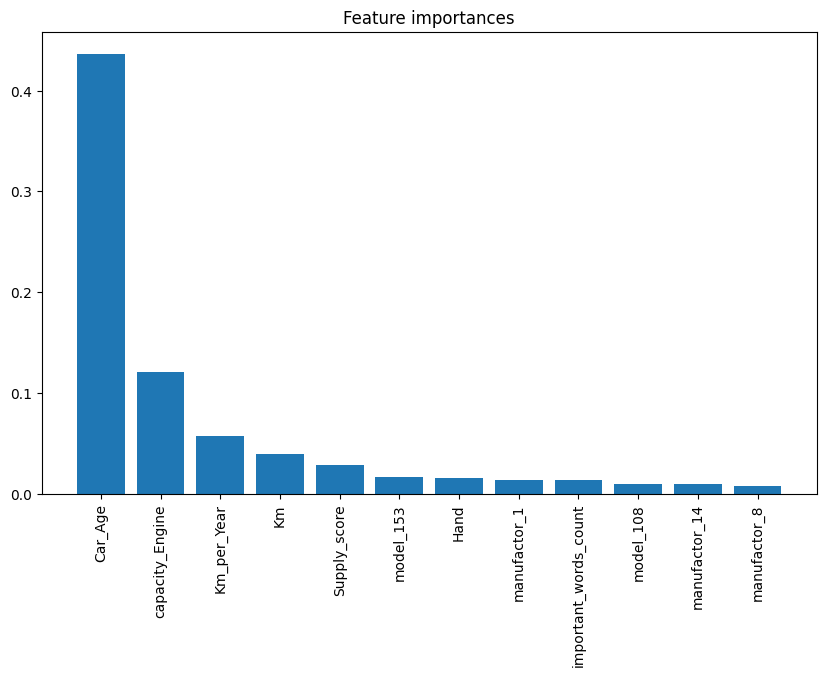

((1200, 12), (300, 12))

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np


# יצירת אובייקט אימפוטר שמשלים ערכים חסרים עם ממוצע העמודה
imputer = SimpleImputer(strategy='mean')

# השלמת ערכים חסרים בסט האימון והבדיקה
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# יצירת מודל רנדום פורסט לבחירת התכונות החשובות ביותר
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train_imputed, y_train)

# קבלת חשיבות התכונות מהמודל
importances = forest.feature_importances_

# סידור התכונות לפי החשיבות
indices = np.argsort(importances)[::-1]

# בחירת מספר מסוים של תכונות חשובות (למשל, 20)
num_features = 12
selected_features = indices[:num_features]

# הצגת התכונות החשובות ביותר
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(num_features), importances[selected_features], align="center")
plt.xticks(range(num_features), [X_train.columns[i] for i in selected_features], rotation=90)
plt.show()

# הפחתת התכונות בסטים
X_train_reduced = X_train_imputed[:, selected_features]
X_test_reduced = X_test_imputed[:, selected_features]

# הצגת צורת הנתונים החדשה
X_train_reduced.shape, X_test_reduced.shape

In [23]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
import numpy as np

model = ElasticNetCV(alphas=np.logspace(-4, 0, 50), l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95], cv=10, random_state=42)
model.fit(X_train_reduced, y_train)

# חיזוי על סט הבדיקה
y_pred = model.predict(X_test_reduced)

# חישוב RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# הצגת RMSE והמשקלים
rmse, sorted(zip(model.coef_, [X_train.columns[i] for i in selected_features]), reverse=True, key=lambda x: abs(x[0]))[:5]


(np.float64(15198.005046132654),
 [(np.float64(-40164.05593514779), 'model_153'),
  (np.float64(21393.628663663556), 'manufactor_14'),
  (np.float64(12441.881065951498), 'manufactor_8'),
  (np.float64(-12288.169768250027), 'Car_Age'),
  (np.float64(8232.50330418071), 'manufactor_1')])

In [24]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import numpy as np

# הגדרת המודל עם Cross-Validation
model = ElasticNetCV(alphas=np.logspace(-4, 0, 50), l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95], cv=10, random_state=42)
model.fit(X_train_reduced, y_train)

import pickle

# נניח שהמודל שלך מאומן ויש לך אותו באובייקט שנקרא `model`
# שמירת המודל כקובץ PKL
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# חישוב RMSE לכל קיפול ב-Cross-Validation
mse_path = model.mse_path_
mean_mse = mse_path.mean(axis=1)  # ממוצע ה-MSE על פני הקיפולים
best_rmse = np.sqrt(mean_mse.min())  # המרת MSE ל-RMSE והצגת ה-RMSE הטוב ביותר

print(f"Best RMSE from CV: {best_rmse}")

# חיזוי על סט הבדיקה
y_pred = model.predict(X_test_reduced)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# הצגת RMSE ותכונות עם המשקל הכי גבוה
print(f"Test RMSE: {test_rmse}")
print("Top 5 features:")
print(sorted(zip(model.coef_, [X_train.columns[i] for i in selected_features]), reverse=True, key=lambda x: abs(x[0]))[:5])

Best RMSE from CV: 14218.268100857715
Test RMSE: 15198.005046132654
Top 5 features:
[(np.float64(-40164.05593514779), 'model_153'), (np.float64(21393.628663663556), 'manufactor_14'), (np.float64(12441.881065951498), 'manufactor_8'), (np.float64(-12288.169768250027), 'Car_Age'), (np.float64(8232.50330418071), 'manufactor_1')]


In [165]:
# טעינת המודל מקובץ PKL
with open('trained_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# בדיקת המודל הטעון
print(loaded_model)


ElasticNetCV(alphas=array([1.00000000e-04, 1.20679264e-04, 1.45634848e-04, 1.75751062e-04,
       2.12095089e-04, 2.55954792e-04, 3.08884360e-04, 3.72759372e-04,
       4.49843267e-04, 5.42867544e-04, 6.55128557e-04, 7.90604321e-04,
       9.54095476e-04, 1.15139540e-03, 1.38949549e-03, 1.67683294e-03,
       2.02358965e-03, 2.44205309e-03, 2.94705170e-03, 3.55648031e-03,
       4.29193426e-03, 5.179474...
       1.93069773e-02, 2.32995181e-02, 2.81176870e-02, 3.39322177e-02,
       4.09491506e-02, 4.94171336e-02, 5.96362332e-02, 7.19685673e-02,
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00]),
             cv=10, l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95], random_state=42)
